# Applied Deep Learning Tutorial 
# Segmentation with U-Net

## Introduction
This tutorial presents a segmentation use-case based on U-Net network (see paper for reference [paper](https://arxiv.org/pdf/1505.04597.pdf)).
First, the theoretical background behind the architecture is discussed. Subsequently you will be guided through the implementation process of the neural network within this Jupyter Notebook. The use-case is based on the initial paper and focuses on cell boundary segmentation, see Fig.1.
<img src="graphics/unet_fig_1.png" width="700"><br>
<center> Figure 1: Right: input image | Left: Prediction of the cell boundaries </center>

## Motivation

While segmentation networks and convolutional neural networks often need a very large amount of training data in order to converge, it is necessary to deploy the training data more efficiently. In segmentation, objects need to be localized and classified. This requires improved semantic understanding. 
The U-Net achieves sample efficiency while capturing both class affiliations and localization performance.  

## What is U-Net

<img src="graphics/unet_fig_2.png" width="700"><br>
<center> Figure 2: U-Net architecture </center>

In Fig.2, the architecture of the U-Net is shown, and it is seen by the shape of the architecture why it is called U-Net.
To understand the U-Net we will walk through the layers step by step, starting with the input.
The input consist out of image's tile. Because only a tile is processed by the network the image can be of an arbitrarily large size and for example it size is not linked to the memory of your GPU. An example of such a tile can be seen in Fig.3 below.
<img src="graphics/unet_fig_3.png" width="300">

<center> Figure 3: Tile of an image </center>

For the yellow part, the center of the tile, the network predict a labeled output whilst the blue region is the region which is fed in to the neural network. Due to this difference there is a overlap-tile strategry to obtaine predicted labels for the whole image and avoid redundant informations.<br> Because a nonpadded image is used with the convolutions, it leads to a 1-pixel loss around the image. 
The convolutions marked with the blue arrows within Fig.2 process the input by building feature maps of the shown size. These convolution a ReLu function is followed. After the first 3 convolutions a feature map of the size 568x568x64 is received. Thereafter max-pooling operation (2x2 with a stride of 2), marked with red arrows in the image, downsample the image size but simultaneously doubles the size of the feature map.<br>
This is repeated until we get a single vector with a high resolution feature map. Thus this contracting path reduces the information of the location by simultaneously increase the context information (features). From this high resolution feature vector, now a high resolution segmentation-map with a high accuracy of the location is built. This is done by expand the vector with up-sampling, due up-convolution and with, and this is the novelty, concatenate the high resolution feature map from the contracting path. This is shown with the grey arrows seen in the Fig.2. Furthermore after every upconcolution a ReLU operation is appended. 
With this combination of knotting the upconcolution of the high resolution feature map with the localization information, it is not getting loss as it is the case with just do an "autoencoding". <br>
Due to the aforementioned loss of information with the nonpadded convolution, the feature map needs to be cropped.
The final layer consists out of a 1x1 convolution which maps each 64 component feature vector to the desired number of classes. And thus devide the image into the requested segments. 

## Implementing the code 

We will orientate with this tutorial on the implemtation of the code from [this](https://github.com/zhixuhao/unet) github repository.
Due to the implementation in Jupyter Notebook we will write the whole code in one template. Instead of different python documents we will use classes.
The original repository consists out of three python documents. To work only with this notebooky every function is integrated here, thus you don't have to switch documents or import other python-files.


In [1]:
# If you do not have the data yet, you can download it here:
# https://github.com/zhixuhao/unet/tree/master/data/membrane
# Now go to the folder in which this jupyter Notebook ist located and running
# and copy the <<data>> folder there and renaming either the folders according
# to the Path written below or change the path written below according to
# your folder-names

When you run the Code below and you set the Path accordingly, an image and its label should be shown.

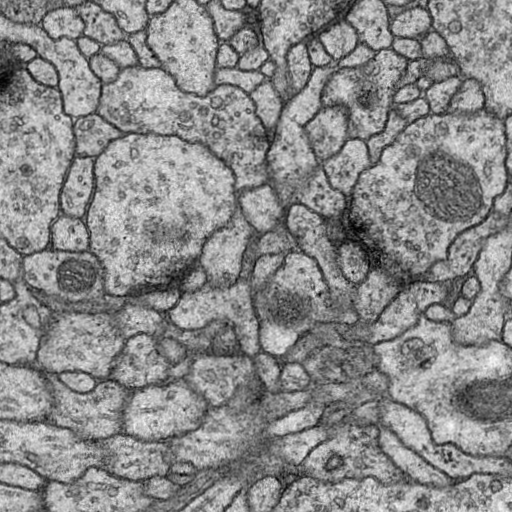

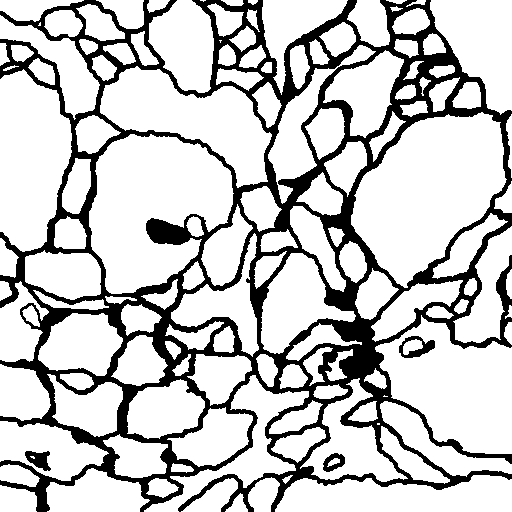

In [2]:
##########################################################
#           In this box some code must be added          #
##########################################################
from IPython.display import Image

# We want to see one of the training data with its label
# Change the folders or the code that the path points to your data
training_images = "data/membrane/train/image/"
training_labels = "data/membrane/train/label/"

# We use the function Image(file_name) to print the image '0.png' and the label 'o.png'
### Insert Code ###
display(Image(training_images + "0.png"))
display(Image(training_labels + "0.png"))

### Buidling the Unet Architecture

In the next box all libraries we will need for the Unet and its dataprepration will be imported. Because Keras is a part of tensorflow and is installed within, we do not have to install in seperately and though can also start it with <br>
"tensorflow.keras"

If something went wrong with importing the packages, you may try to restart your kernel.

In [3]:
from __future__ import print_function

import glob
import os

import numpy as np
import skimage.io as io  # pip install scikit-image pip install scipy

# if This Error occurs:
# <<ImportError: cannot import name 'rgb2gray'>>
# restart your kernel
import skimage.transform as trans
import tensorflow as tf
from keras import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import image_dataset_from_directory

To build the archtecture which is shown in fig.1 keras is a very intuitive and simply way to do so. We will slithly adapt the archtecture from the original one like seen in fig.3. To build this neural net We do need the following functions:
- 2D Convolution
- MaxPooling 
- Concatenation

We will add an Dropout after convolution 4 and 5,  please explain what could be the purpose to add those two layers:



Dropout, deactivates some weights/connections for the trainings step that the network is more robust and don't learn into a local minima





Let's start coding the Network with the following functions:

- Conv2D(filters/feature maps, kernel size, activation, padding, kernel_initializer)(input Data)
- MaxPooling2D(pool_size = (x,x))(input Data)
- Dropout(dropout rate)(input Data)
- concatenate([input Data 1, Input Data 2], axis= x)
- Conv2D()(UpSampling2D(size=(x,x))(Input Data)

As activation function we take 'relu' (Rectified Linear Unit).
As padding we chose 'same', thus despite convolution we get an output of the same size as the input.
The kernel initializer defines how we want to set the initial weights of this Keras layer. For example:
- Zeros: initialize with a tensor of zeros
- Ones: initialize with a tensor of ones
- RandomNormal: initialize the tensor with a normal distribution
- TruncatedNormal: initialize the tensor with a truncated normal distribution, where all values more than two standard deviations from its mean are neglected
- he_normal: a zero mean Gaussian distribution with a standard deviation of \sqrt{(2/n)}, where n is the number of inputs/connections of our weight tensor <br>

Which initialization do you think is beneficial?


he_normal has shown good results, and bypasses dead neurons.


<br>
When the architecture is configured correctly we have to define the inputs and outputs of our Neural Network with the method: <br> Model(inputs= ___ , outputs= __).
Thereafter we need to compile the whole architecture for training. Therefor we need to define the optimizer (with a proper learning rate) the loss function and we can evaluate define on which metrics we want to evaluate our model. 

List 3 loss functions and 3 optimizers and explain them:



Loss function:
- mean squared error:
- (squared) hinge:
- crossentropy:
- dice-loss
- poisson:

Optimizers:
- Stochastic Gradient Descent:
- RMSprop:
- Adagrad:
- Adam Optimizer:

<br>
Chose one of these optimizers you thing fit best for your Unet and also a proper learning rate.
The return of our function should be the model.


## The Dice Coefficient Loss

In this section we will implement the Dice Coefficient loss, so we can use it with our own model.
The Dice Coefficient, also known as Sørensen–Dice coefficient compars the similarity of two quantities. When working with neural network these are, the prediction of our network and the ground truth. The dice coefficient can be interpreted as Intersection over union, so to speak points which appear in the predicition and ground truth, this makes it very attractive to use it on tasks with bounding boxes, image segmentation etc.
<br>
The formular of the dice loss is given with:
\begin{align}
    DSC = \frac{2*|X \cap Y|}{|X|+|Y|}
\end{align}

Befor conding this formula you may think about:
   - do I need the absolut values?
   - how can i easily calculate the intersection, assuming that the ground truth is a one-hot vector:
    \begin{align}
        y_{true} = \begin{bmatrix}
        0.0 &  0.0 &  0.0 &  1.0
        \end{bmatrix}
    \end{align}
    \begin{align}
        y_{pred} = \begin{bmatrix}
        0.1 &  0.2 &  0.0 &  0.7
        \end{bmatrix}
    \end{align}
<br>

Now start with the coding, following these steps 
- First we want to flatten our input to the loss y_true and y_pred
- Calculate the counter with its intersection
- Calulate the denominator, (you may want to add a small epsilon to it)
- Obtain the coefficient

Because we work here with the backend of keras, we need to do our operations with K.operation.
K is the backend we imported above with "from tensorflow.keras import backend as K".
Here a list of some operations is listed, if you need more, just google them:
- sum: K.sum()
- flatten: K.flatten()
- mean: K.mean()
- reshape: K.reshape()
- dot: K.dot()
- epsilon: K.epsilon()

In [4]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    coef = (2.0 * intersection + K.epsilon()) / (
        K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon()
    )
    return coef

Why it is advised to add an epsilon to your denominator?


In [5]:
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [6]:
##########################################################
#           In this box some code must be added          #
##########################################################


def unet(
    pretrained_weights=None, input_size=(256, 256, 1)
):  # the values given for the parameters are the default values
    inputs = Input(input_size)
    conv1 = Conv2D(
        64, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(inputs)
    conv1 = Conv2D(
        64, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(
        128, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(pool1)
    conv2 = Conv2D(
        128, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(
        256, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(pool2)

    conv3 = Conv2D(
        256, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(
        512, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(pool3)
    conv4 = Conv2D(
        512, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(
        1024, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(pool4)
    conv5 = Conv2D(
        1024, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(
        512, 2, activation="relu", padding="same", kernel_initializer="he_normal"
    )(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(
        512, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(merge6)
    conv6 = Conv2D(
        512, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv6)

    up7 = Conv2D(
        256, 2, activation="relu", padding="same", kernel_initializer="he_normal"
    )(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(
        256, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(merge7)
    conv7 = Conv2D(
        256, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv7)

    up8 = Conv2D(
        128, 2, activation="relu", padding="same", kernel_initializer="he_normal"
    )(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(
        128, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(merge8)
    conv8 = Conv2D(
        128, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv8)

    up9 = Conv2D(
        64, 2, activation="relu", padding="same", kernel_initializer="he_normal"
    )(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(
        64, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(merge9)
    conv9 = Conv2D(
        64, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv9)
    conv9 = Conv2D(
        2, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv9)

    # In the last layer we chose the <sigmoid> as activation function because the output has to be between zero and one.
    # We normalized out pixle values by deviding through 255.
    # For our example we have only one class and thus only needing
    # zero being white (our predicted object-segment) and 1 beeing black.
    # but if we have more that one class the different colors will also lie inbetween 0 and 1 and every
    # prediction is labeld with the appropriate number.
    conv10 = Conv2D(1, 1, activation="sigmoid")(conv9)

    # With the following method <Model> we define out input and output of or Neural Network
    # please complete:
    model = Model(inputs=inputs, outputs=conv10)

    # with Model.compile we configure and prepare our netwrok for training. Thus we define our optimizer for
    # learning with it's learning rate, the loss function and the metrics.
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    # model.compile(optimizer=SGD(learning_rate=1e-4), loss=dice_coef_loss, metrics=['accuracy'])
    # model.compile(optimizer=SGD(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    # model.summary()

    # this part we need for resume to a training or printing test, results for an already trained network, be careful
    # that the input_size you defined for the model match with the one you defined for the model you take the pretrained
    # weights from!
    if pretrained_weights:
        model.load_weights(pretrained_weights)

    return model

### Preparing the Data

So far we build the architecture of our neural net and the data, consists out of images and labels. To train the neural network in the next step the data has to be prepared.


#### Adjusting and Augmenting the Data

Before we feed the data to our neural network, it has to be adjusted properly. 
The first step always helps is to normalize our input data. Important is to normalize both the labels and the images, so that the neural network does not learn something wrong, warped or even nothing at all.
In this tutorial we got the binary case and therefor the images and masks just need to be normalized.
This is done by dividing through 255. 
The way we augment data in modern tensorflow is to use a Sequential model with augmentation layers, that return the input tensor in an augmented way. By using these layers we never need to convert our input tensors we created into a different format and can just later on run the input tensors and the labeled output tensors through the same model and get our augmented pair. 
It is very important to use the same seed in both `` adjust_training_images `` and `` adjust_training_masks ``, because if we for example rotate an image, the corresponding laber has to be rotated in the same way.

In [7]:
##########################################################
#           In this box some code must be added          #
##########################################################
def adjust_training_images(
    rotation_range: float,
    width_shift_range: float,
    height_shift_range: float,
    zoom_range: float,
    resize_height: int,
    resize_width: int,
    flip="horizontal",
    interpolation="nearest",
    seed=1,
):

    sequential_augmentation = Sequential(
        [
            tf.keras.layers.Rescaling(scale=1.0 / 255.0),
            tf.keras.layers.RandomRotation(
                factor=rotation_range, interpolation=interpolation, seed=seed
            ),
            tf.keras.layers.RandomZoom(
                height_factor=zoom_range,
                width_factor=zoom_range,
                fill_mode="reflect",
                interpolation=interpolation,
                seed=seed,
            ),
            tf.keras.layers.RandomFlip(mode=flip, seed=seed),
            tf.keras.layers.RandomHeight(
                factor=height_shift_range, interpolation=interpolation, seed=seed
            ),
            tf.keras.layers.RandomWidth(
                factor=width_shift_range, interpolation=interpolation, seed=seed
            ),
            tf.keras.layers.Resizing(
                resize_height,
                resize_width,
                interpolation="bilinear",
                crop_to_aspect_ratio=False,
            ),
        ]
    )
    return sequential_augmentation


def adjust_training_masks(
    rotation_range: float,
    width_shift_range: float,
    height_shift_range: float,
    zoom_range: float,
    resize_height: int,
    resize_width: int,
    flip="horizontal",
    interpolation="nearest",
    seed=1,
):

    sequential_augmentation = Sequential(
        [
            tf.keras.layers.Rescaling(scale=1.0 / 255.0),
            tf.keras.layers.RandomRotation(
                factor=rotation_range, interpolation=interpolation, seed=seed
            ),
            tf.keras.layers.RandomZoom(
                height_factor=zoom_range,
                width_factor=zoom_range,
                fill_mode="reflect",
                interpolation=interpolation,
                seed=seed,
            ),
            tf.keras.layers.RandomFlip(mode=flip, seed=seed),
            tf.keras.layers.RandomHeight(
                factor=height_shift_range, interpolation=interpolation, seed=seed
            ),
            tf.keras.layers.RandomWidth(
                factor=width_shift_range, interpolation=interpolation, seed=seed
            ),
            tf.keras.layers.Resizing(
                resize_height,
                resize_width,
                interpolation="bilinear",
                crop_to_aspect_ratio=False,
            ),
        ]
    )
    return sequential_augmentation


rescale_data = Sequential([tf.keras.layers.Rescaling(scale=1.0 / 255.0)])

#### The training Generator

The next function will be the ``trainGenerator``.
Because deep learning task only get to learn something if they are trained with a lot of data, we have to provide it. But with the data we downloaded, there are only 30 images in the folder ``train/``. For a deep learning trask that is way to little. Therefor we will generating our own data with data augmentation. This function will use the data augmentation layers created above on the given images with layers like RandomRotation, RandomFlip and RandomZoom etc. Here the most important is that labels and images are transformed together with the same transformation functions. How good such an augmentation can replace more recordings strongly depends from the data on which we will learn. But for the given task the data augmentation works really good.
The function used here to generate the Data is the image_dataset_from_directory provided within Keras. The documentations for more information can be found here 
https://keras.io/preprocessing/image/.

To use the image augmentation function from above, we map the output onto the augmentation function. 

Why is it do important that you will chose the same seed for the mask and the image itself and what does seed stand for?



In [8]:
def trainGenerator(
    batch_size,
    train_path,
    image_folder,
    mask_folder,
    aug_dict,
    image_color_mode="grayscale",
    mask_color_mode="grayscale",
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    """
    # create two augmentation sequences with the same seed, to augment the images and the labels in the same way.
    # This is crucial because otherwise the labels wouldn't fit the images anymore.
    image_augmentation = adjust_training_images(**aug_dict)
    mask_augmentation = adjust_training_masks(**aug_dict)

    # Here we create a generator object and the map the augmentation and rescaling Sequences on the generators.
    image_generator = (
        image_dataset_from_directory(
            train_path + "/" + image_folder,
            labels=None,
            label_mode="binary",
            color_mode=image_color_mode,
            image_size=target_size,
            batch_size=batch_size,
            seed=seed,
        )
        .repeat()
        .map(lambda x: image_augmentation(x))
    )

    mask_generator = (
        image_dataset_from_directory(
            train_path + "/" + mask_folder,
            labels=None,
            label_mode="binary",
            color_mode=mask_color_mode,
            image_size=target_size,
            batch_size=batch_size,
            seed=seed,
        )
        .repeat()
        .map(lambda x: mask_augmentation(x))
    )

    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)


# to understand what yield is: https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do

#### The Testing Generator

The testGenerator function will generate your test data on the images provided within the test folder. 
It will first read the images from the test-folder as gray images normalize them and resize them like defined in with the parameter target_size. Depending on the amount of object-classes you need the image vector will be extended. For our purpose again it is not necessary.  

In [9]:
def testGenerator(test_path, image_color_mode="grayscale", target_size=(256, 256)):

    image_generator = image_dataset_from_directory(
        test_path,
        labels=None,
        label_mode="binary",
        color_mode=image_color_mode,
        image_size=target_size,
        batch_size=2,
        shuffle=False,
    ).map(lambda x: (rescale_data(x)))

    return image_generator

#### The visualizer of the labels and predictions

In [10]:
def labelVisualize(num_class, img):
    img = img[:, :, 0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i, :] = color_dict[i]
    return img_out / 255

#### Saving the results

In [11]:
def saveResult(save_path, npyfile, num_class=2):
    for i, item in enumerate(npyfile):
        img = np.array(item[:, :, 0] * 255, dtype=np.uint8)
        io.imsave(os.path.join(save_path, "%d_predict.png" % i), img)

## Run the training

Now all functions we need to run our Unet are defined and thus we can start the training.

First we need to augmentate our dataset which contains up to now only 30 images.
Therefor we can define some parameters within out data augmentation dictionary ``data_gen_args`` for this augmentation. To get some results and not just a gray image as prediciton, you should start with small parameters here.

Then we will generate the data with the beforehand defined parameters and the images given in the training folder. 
The first number hereby defines the batch_size, which you can change to a bigger number if your Computer fill in the requirements (GPU, Memory).

Now it is time to built our UNet with just calling the function and than start the traing.
You can change the "steps_per_epoch" and "epochs". The more you chose the better the results will get but also the longer the training will take.
The Checkpoint-file will be saved within your Jupter Notebook folder.

In [12]:
data_gen_args = dict(
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    resize_height=256,
    resize_width=256,
    flip="horizontal",
    interpolation="nearest",
)

myGene = trainGenerator(2, "data/membrane/train", "image", "label", data_gen_args)

model = unet()
model_checkpoint = ModelCheckpoint(
    "unet_membrane.hdf5", monitor="loss", verbose=1, save_best_only=True
)
model.fit(myGene, steps_per_epoch=299, epochs=5, callbacks=[model_checkpoint])

Found 30 files belonging to 1 classes.
Found 30 files belonging to 1 classes.
Epoch 1/5
299/299 [==============================] - ETA: 0s - loss: 0.3258 - accuracy: 0.8138
Epoch 1: loss improved from inf to 0.32584, saving model to unet_membrane.hdf5
299/299 [==============================] - 42s 120ms/step - loss: 0.3258 - accuracy: 0.8138
Epoch 2/5
299/299 [==============================] - ETA: 0s - loss: 0.1758 - accuracy: 0.8802
Epoch 2: loss improved from 0.32584 to 0.17578, saving model to unet_membrane.hdf5
299/299 [==============================] - 37s 122ms/step - loss: 0.1758 - accuracy: 0.8802
Epoch 3/5
299/299 [==============================] - ETA: 0s - loss: 0.1375 - accuracy: 0.8961
Epoch 3: loss improved from 0.17578 to 0.13748, saving model to unet_membrane.hdf5
299/299 [==============================] - 36s 121ms/step - loss: 0.1375 - accuracy: 0.8961
Epoch 4/5
299/299 [==============================] - ETA: 0s - loss: 0.1114 - accuracy: 0.9066
Epoch 4: loss improve

## Test your Model

When the training is done you can generate some prediction on your test data and save them within the test-image folder.

In [13]:
testGene = testGenerator("data/membrane/test", target_size=(256, 256))
results = model.predict(testGene, 30, verbose=1)

if not os.path.exists("data/prediction"):
    os.mkdir("data/prediction")

saveResult("data/prediction", results)

Found 30 files belonging to 1 classes.
15/15 [==============================] - 1s 46ms/step


### Show the results

We can now either look in the folder how well our network was trained or just show some images and their predicitons here:


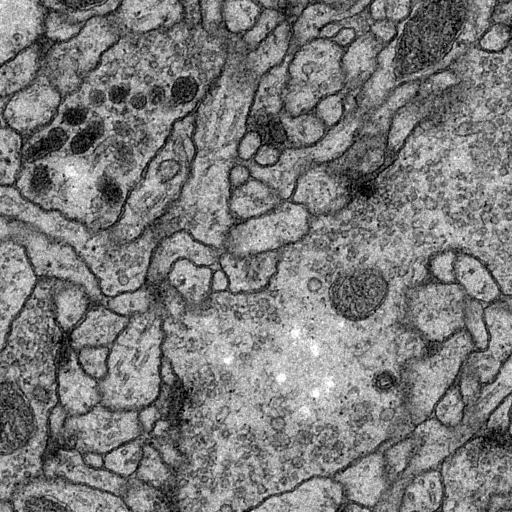

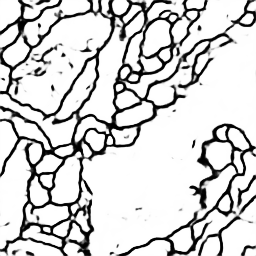

In [14]:
test_path = "data/membrane/test/"
predict_path = "data/prediction/"
# number 0 to 29 your want to show
img_number = 1
display(Image(test_path + str(img_number) + ".png"))
display(Image(predict_path + str(img_number) + "_predict.png"))

## What's next

Some ideas of what you can do next

- Try on cars 
- try on dataset with multiple labels 
- try on zebrafish repository (https://osf.io/snb6p/)
- adapt architecture (loss, learning-rate,...)

Sources:<br>
[Fig2](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)<br>
[Fig3](https://arxiv.org/pdf/1505.04597.pdf) (from the paper) <br>

https://tuatini.me/practical-image-segmentation-with-unet/